In [1]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.data import Batch
import torch.nn as nn
from sklearn.manifold import TSNE
from rdkit import Chem
%matplotlib inline
import matplotlib.pyplot as plt
from GNN import GNN
from Dataset import XASDataset
from utils import plot_spectra,plot_learning_curve

/p/software/juwelsbooster/stages/2023/software/tqdm/4.64.0-GCCcore-11.3.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define routines to be used

In [2]:
def train(epoch):
    model.train()
    loss_all = 0
    node_list=[]
    select_list=[]
    tot_list=[]
    smiles_list=[]
   # batch_size=128
    for batch in train_loader:
        
        #print(batch.idx,batch.smiles)
        batch = batch.to(device)
        #x, edge_index,index = batch.x,batch.edge_index,batch.index
       
        #print(batch.idx,batch.atom_index)
        # Add batch dimension to index
        #batch_index = index.unsqueeze(1)

        optimizer.zero_grad()
        
        pred= model(batch)
        batch_size= batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)
        #pred = torch.clamp(pred, min=0.0)
        #print(batch.y.shape)
        #new_pred=pred.view(batch.y[:,0:99].shape)

        #pred=ss[0]
        #emb=ss[1]
        alpha=10

        #loss = nn.MSELoss()(pred.view(-1, 1).double(), 
        #                batch.y[:,:100].view(-1, 1).double()) 
        
        loss = nn.MSELoss()(pred.double(), 
                       batch.y.double()) 
       # + alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))
        
        #p_loss=nn.SmoothL1Loss()(new_pred.double(), 
        #                batch.y.double())
        
        #loss=nn.SmoothL1Loss()(pred.view(-1, 1).double(), 
        #                batch.y.view(-1, 1).double())
        #print(loss)
        #print(pred.view(-1, 1).double(), batch.y.view(-1, 1).double())
       # pred_list.append(pred.view(-1, 1).double())
        #y_list.append(batch.y.view(-1, 1).double())
        
        loss.backward()
        #print(batch.num_graphs)
        loss_all += loss.item() * batch.num_graphs
        optimizer.step()
        
#        if epoch==999 :
#            node_list.append(node)
#            select_list.append(select)
#            smiles_list.append(batch.smiles)
#            tot_list.append(tot)
#    a=0
#    b=0
#    c=0
#    d=0
#    if epoch==999:
#        a=node_list
#        b=select_list
#        c=smiles_list
#        d=tot_list
    
    #print(len(train_loader.dataset))
        #emb_list.append(emb)
    return loss_all / len(train_loader.dataset)

In [3]:
def test(loader):
    model.eval()
    loss_all = 0

    for batch in loader:
        batch = batch.to(device)
        #x, edge_index, index = batch.x, batch.edge_index, batch.index
        
        # Add batch dimension to index
        #batch_index = index.unsqueeze(1)
        batch_size=batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)

        with torch.no_grad():
            pred = model(batch)
        
        
        #print(pred)
   #     alpha=10
       # loss = nn.MSELoss()(pred.view(-1, 1).double(),
        #                  batch.y.view(-1, 1).double()) 
        
        loss = nn.MSELoss()(pred.double(),
                          batch.y.double()) 
    #    +alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))
       # loss=nn.SmoothL1Loss()(pred.view(-1, 1).double(), 
       #                 batch.y.view(-1, 1).double())
        loss_all += loss.item() * batch.num_graphs

    return loss_all / len(loader.dataset)


In [4]:
def pred_spec(model,index,test_dataset):
    # Set the model to evaluation mode
    model.eval()

    # Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])

    # Pass the graph through the model
    with torch.no_grad():
        pred = model(batch)

    # Access the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.y.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum,true_spectrum

#### Load the data

In [5]:
path='/p/project/hai_ml_xas/Sam_ML/GO_molecule_GNN'
dataset = XASDataset(path)

Processing...


Total number of molecules 319
Number of atoms in each molecule  [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 26, 25, 26, 26, 24, 24, 24, 24, 25, 24, 25, 24, 24, 26, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 24, 25, 24, 24, 24, 26, 26, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 27, 26, 25, 26, 26, 26, 26, 25, 26, 25, 25, 26, 26, 26, 26, 25, 25, 27, 27, 27, 25, 27, 25, 27, 28, 27, 28, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 25, 28, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 24, 24, 24, 24, 25, 24, 24, 24, 24, 25, 25, 24, 25, 25, 25, 25, 24, 24, 24, 26, 26, 26, 26, 26, 26, 27, 24, 27, 28, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 24, 25, 24, 27, 24, 24, 25, 24, 24, 26, 25, 25, 25, 25, 25, 25, 25,

Done!


In [6]:
print('Total number of data points in the dataset:', len(dataset))

Total number of data points in the dataset: 319


#### Split into test, validation and test datasets

In [7]:
train_dataset = dataset[0:240]
val_dataset = dataset[240:280]
test_dataset = dataset[280:]

In [8]:
train_dataset[0]

Data(x=[30, 16], edge_index=[2, 76], y=[200], edge_attrs=[76, 7], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[cH:11][cH:14][c:15]6[c:13]4[c:17]4[c:19]([cH:18][cH:16]6)[cH:20][c:22]([OH:25])[c:23]([c:21]14)[CH2:24][CH:1]1[C:2]2([CH:3]=[CH:5][C:6]32[CH:7]([CH:9]5[C:12](=[O:26])[OH:27])[O:29]2)[O:28]1')

In [29]:
test_loader = DataLoader(test_dataset, batch_size=15, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=15, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)

#### Set neural network properties

In [30]:
num_tasks = 200
num_layers = 4
emb_dim = dataset.num_features
print(emb_dim)
in_channels = [int(emb_dim),100,200,300]
print(in_channels)
out_channels = [100,200,300,300]
gnn_type = 'gcn'
heads = int(1)
drop_ratio = 0.8
graph_pooling = 'sum'

16
[16, 100, 200, 300]


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(num_tasks,num_layers,emb_dim,in_channels,out_channels,gnn_type,heads,drop_ratio,graph_pooling)
model= model.to(device)

In [32]:
model

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(16, 100)
      (1): GCNConv(100, 200)
      (2): GCNConv(200, 300)
      (3): GCNConv(300, 300)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=300, out_features=200, bias=True)
)

In [33]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                    factor=0.5, patience=100,
                                                    min_lr=0.000001)
#scheduler =torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,300,500], gamma=0.5)

#### Run neural network training

In [34]:
best_val_error=None
train_losses = []
val_losses = []

for epoch in range(0, 1000):
    
    loss = train(epoch)
    
    val_error = test(val_loader)
    scheduler.step(val_error)
    #scheduler.step(epoch)
    train_losses.append(loss)
    val_losses.append(val_error)
    
    current_lr = optimizer.param_groups[0]['lr']
    


    if best_val_error is None or val_error <= best_val_error:
        
        best_val_error = val_error
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}')


Epoch: 000, LR: 0.010000, TrainLoss: 18.1931704, ValLoss:2.974760, Best_ValLoss:2.974760
Epoch: 010, LR: 0.010000, TrainLoss: 1.5951340, ValLoss:0.837459, Best_ValLoss:0.837459
Epoch: 020, LR: 0.010000, TrainLoss: 0.4799183, ValLoss:0.281800, Best_ValLoss:0.281800
Epoch: 030, LR: 0.010000, TrainLoss: 0.1651521, ValLoss:0.070675, Best_ValLoss:0.070675
Epoch: 040, LR: 0.010000, TrainLoss: 0.0493471, ValLoss:0.022461, Best_ValLoss:0.022461
Epoch: 050, LR: 0.010000, TrainLoss: 0.0281793, ValLoss:0.017487, Best_ValLoss:0.015709
Epoch: 060, LR: 0.010000, TrainLoss: 0.0244492, ValLoss:0.016129, Best_ValLoss:0.015309
Epoch: 070, LR: 0.010000, TrainLoss: 0.0221931, ValLoss:0.013950, Best_ValLoss:0.013950
Epoch: 080, LR: 0.010000, TrainLoss: 0.0216345, ValLoss:0.017296, Best_ValLoss:0.013483
Epoch: 090, LR: 0.010000, TrainLoss: 0.0195500, ValLoss:0.014674, Best_ValLoss:0.013483
Epoch: 100, LR: 0.010000, TrainLoss: 0.0206180, ValLoss:0.022205, Best_ValLoss:0.013483
Epoch: 110, LR: 0.010000, Train

In [35]:
torch.save(model.state_dict(), 'model_gnn.pt')

#### View loss

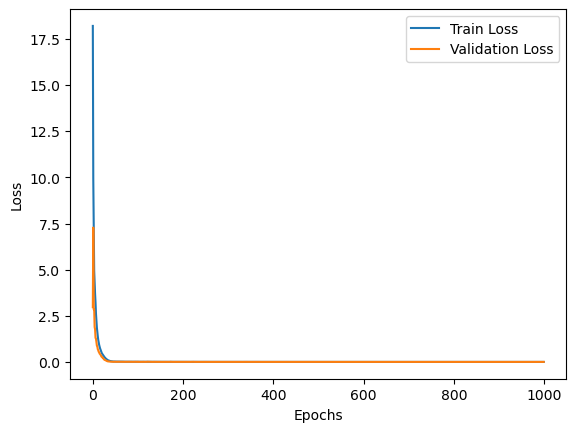

In [36]:
num_e=1000

plot_learning_curve(num_e,train_losses,val_losses)

In [37]:
# Load the saved model
model =GNN(num_tasks,num_layers,emb_dim,in_channels,out_channels,gnn_type,heads,drop_ratio,graph_pooling)
model=model.to(device)
model.load_state_dict(torch.load('model_gnn.pt'))


<All keys matched successfully>

#### Plot predicted spectra

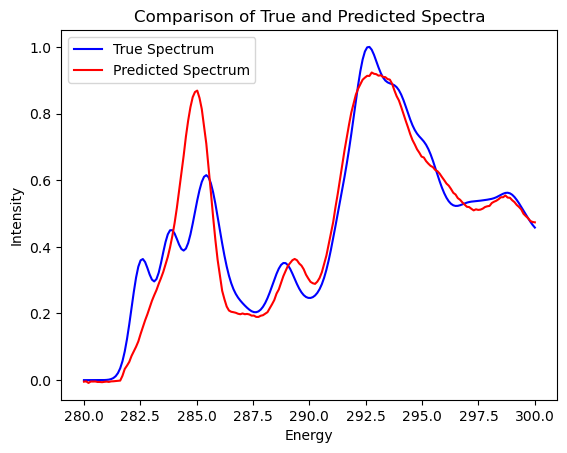

In [49]:
save_var=1
p1,t1=pred_spec(model,20,test_dataset)

plot_spectra(p1, t1,save_var)

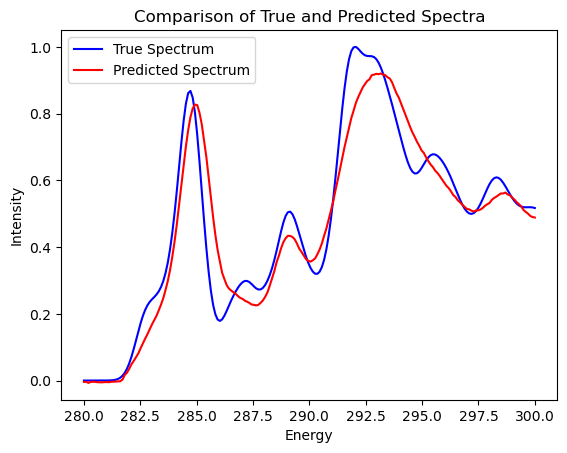

In [41]:

p2,t2=pred_spec(model,24,test_dataset)

plot_spectra(p2, t2,save_var)

In [ ]:
spec_examples={'p1':p1,'t1':t1,'p2':p2,'t2':t2}


In [ ]:
import pickle 

with open("E:/hlrn_orca/ml_preds.pkl", "wb") as file:
    pickle.dump(spec_examples, file)

In [ ]:
t0=train_dataset[30]

In [ ]:
t0.x

In [ ]:
model.eval()
for batch in train_loader:
    batch=batch.to(device)
    embeddings = model.forward(batch)

In [ ]:
embeddings[1][0]

In [ ]:
embeddings[1][1]